# **SECTION 1 : Importation des bibliothèques et configuration initiale**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Pour utiliser EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
# Montage Google Drive (si besoin)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SECTION 2 : Chargement et exploration des données UTKFace**

In [3]:
# Décompression du dataset UTKFace depuis Google Drive
!unzip /content/drive/MyDrive/UTKFace.zip -d UTKFace

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: UTKFace/utkface_aligned_cropped/crop_part1/34

In [46]:
# Dictionnaire des chemins vers les différentes parties du dataset
data_paths = {
    "full": "/content/UTKFace/UTKFace/",
    "part": "/content/UTKFace/utkface_aligned_cropped/UTKFace/",
    "test": "/content/faces/"  # dossier contenant des images tests
}

In [47]:
# Dictionnaire pour l'affichage du genre
genders = {0: "Male", 1: "Female"}

In [51]:
# Paramètres d'entraînement
BATCH_SIZE = 128
IMG_SIZE = (200, 200)
IMG_SHAPE = IMG_SIZE + (3,)

In [52]:
def get_image(filepath):
    """Charge et prétraite une image pour EfficientNet."""
    image = Image.open(filepath).convert("RGB")
    image = image.resize(IMG_SIZE)
    image = np.array(image)
    image = preprocess_input(image)  # Normalisation adaptée à EfficientNet
    return image

def load_data_UTKFace(directory, stop=-1):
    """
    Parcourt le dossier et charge les images ainsi que les labels (âge et genre).
    Le paramètre stop permet d'arrêter après un certain nombre d'images si nécessaire.
    """
    images, age_y, gender_y = [], [], []
    files = os.listdir(directory)
    random.shuffle(files)
    for file in tqdm(files):
        if stop != -1 and len(age_y) >= stop:
            break
        try:
            # Les noms de fichiers sont supposés avoir le format : age_gender_...
            age, gender = map(int, file.split("_")[:2])
        except Exception as e:
            continue  # en cas d'erreur de parsing, on passe l'image
        images.append(get_image(os.path.join(directory, file)))
        age_y.append(age)
        gender_y.append(gender)
    return np.array(images), np.array(age_y), np.array(gender_y)

In [53]:
# Chargement des données depuis le dossier "full"
images, age_y, gender_y = load_data_UTKFace(data_paths["full"])

100%|██████████| 23708/23708 [00:12<00:00, 1875.75it/s]


In [54]:
# Constitution des labels combinés : [âge, genre]
labels = np.stack((age_y, gender_y), axis=1)

In [55]:
# Affichage du nombre d'images
print("Nombre total d'images chargées :", len(images))

Nombre total d'images chargées : 23708


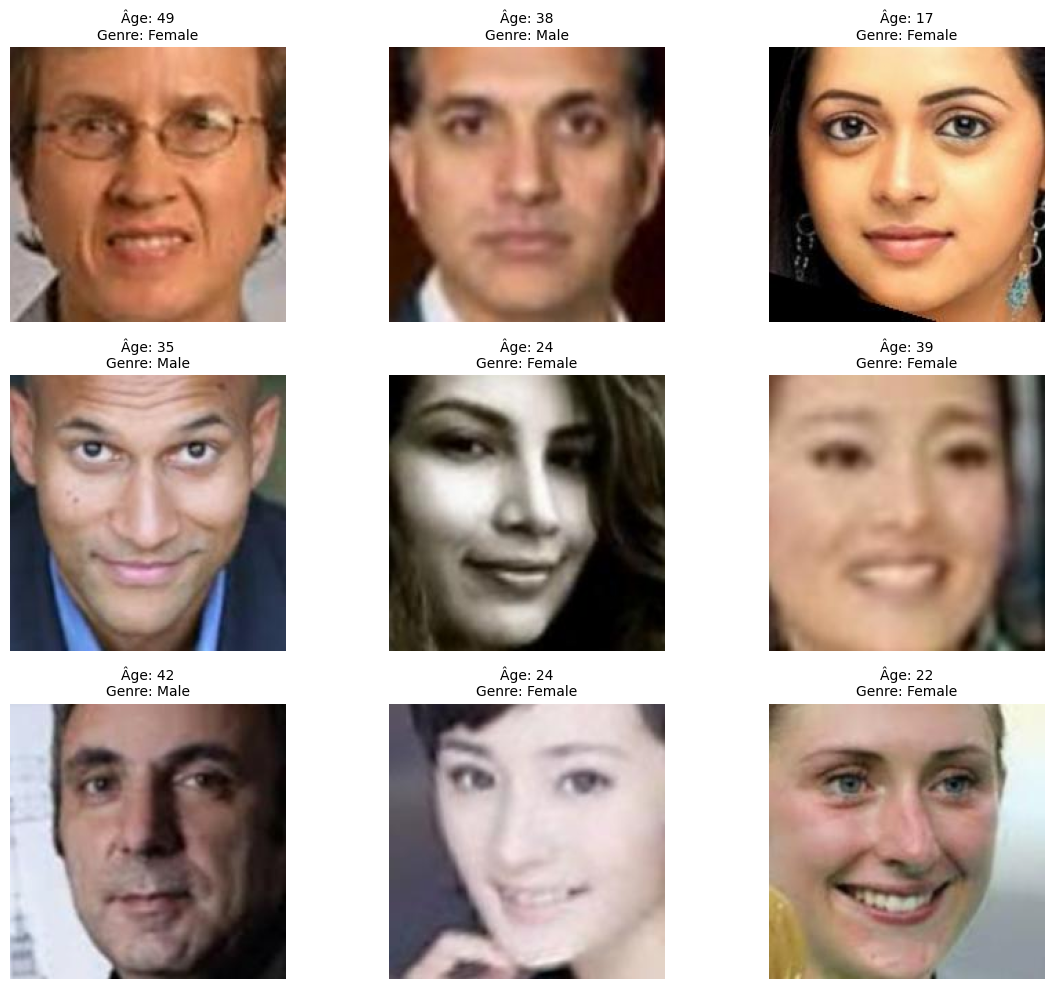

In [56]:
# --- Affichage d'un échantillon d'images aléatoires avec leurs labels ---
def display_random_images(images, labels, num_images=9):
    """Affiche num_images images aléatoires avec leurs labels d'âge et de genre."""
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(indices):
        img = images[idx]
        age, gender = labels[idx]
        # Normalisation min-max pour que les valeurs soient dans [0,1]
        img_disp = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.subplot(3, 3, i+1)
        plt.imshow(img_disp)
        plt.title(f"Âge: {age}\nGenre: {genders[gender]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_random_images(images, labels)

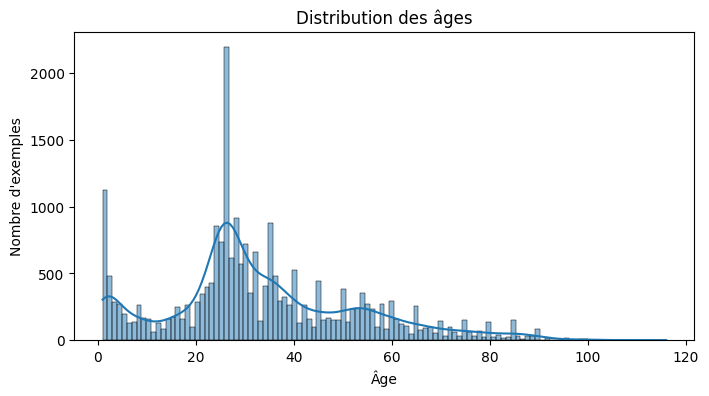

In [57]:
# --- Statistiques sur le dataset ---
# Distribution des âges
plt.figure(figsize=(8, 4))
sns.histplot(age_y, bins=max(age_y), kde=True, stat="count")
plt.xlabel("Âge")
plt.ylabel("Nombre d'exemples")
plt.title("Distribution des âges")
plt.show()

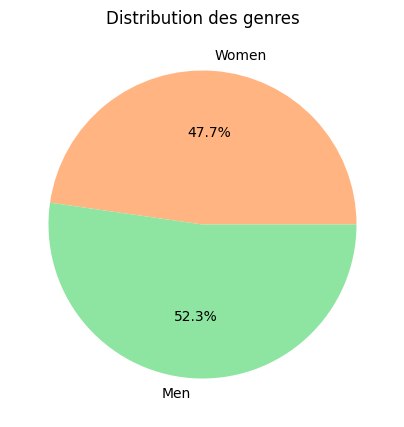

In [58]:
# Distribution du genre (pie chart)
women = np.count_nonzero(gender_y)
men = len(gender_y) - women
plt.figure(figsize=(5, 5))
plt.pie([women, men], labels=["Women", "Men"], colors=sns.color_palette("pastel")[1:3], autopct='%1.1f%%')
plt.title("Distribution des genres")
plt.show()

In [59]:
# Calcul du poids des classes pour le genre (binaire)
gender_class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(gender_y),
    y=gender_y
)
gender_class_weights = {i: weight for i, weight in enumerate(gender_class_weights)}
print("Gender Class Weights:", gender_class_weights)

Gender Class Weights: {0: 0.9566620934549269, 1: 1.0474507378280462}


In [60]:
# Calcul des poids pour l'âge (pour le MAE pondéré)
age_counts = np.bincount(age_y)
age_weights = 1 / np.maximum(age_counts, 1)  # évite division par 0
age_weights /= np.max(age_weights)  # normalisation entre 0 et 1

In [61]:
# Séparation en ensembles train / validation
train_x, val_x, train_y, val_y = train_test_split(images, labels, test_size=0.2, random_state=42)

# **SECTION 3 : Prétraitement et création des datasets tf.data**

In [62]:
def preprocess(image, label):
    """Redimensionne, normalise l'image et sépare les labels."""
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    age = label[0]
    gender = label[1]
    return image, (age, gender)

def create_dataset(images, labels, batch_size=32, training=True):
    """
    Crée un pipeline tf.data :
      - conversion en tf.float32,
      - shuffling (pour l'entraînement),
      - application du prétraitement,
      - mise en batch, mise en cache et prefetch.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32), lbl),
                          num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(1000)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_x, train_y, BATCH_SIZE, training=True)
val_dataset   = create_dataset(val_x, val_y, BATCH_SIZE, training=False)

# **SECTION 4 : Construction du modèle à base de EfficientNetB0**

In [63]:
# Data augmentation : la séquence intègre une couche Lambda pour ajuster la luminosité
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.2))
], name="data_augmentation")

In [64]:
# Chargement du modèle de base EfficientNetB0 avec les poids d'ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)
print("Nombre de couches dans base_model :", len(base_model.layers))
base_model.summary()

Nombre de couches dans base_model : 238


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 200, 200, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 200, 200, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 200, 200, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 201, 201, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 100, 100, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 100, 100, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 100, 100, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 100, 100, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 100, 100, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 100, 100, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [65]:
# Définition d'une fonction de perte personnalisée pour l'âge (MAE pondéré)
def weighted_mae(y_true, y_pred):
    """Calcul du MAE pondéré en fonction de l'âge."""
    age_bin = tf.cast(y_true, tf.int32)
    weight = tf.gather(tf.constant(age_weights, dtype=tf.float32), age_bin)
    return K.mean(weight * K.abs(y_true - y_pred))

In [66]:
# Construction de la tête du modèle pour la prédiction de l'âge et du genre
# Input et data augmentation
inputs = tf.keras.Input(shape=IMG_SHAPE, name="input_image")
x = data_augmentation(inputs)
x = preprocess_input(x)

In [67]:
# Passage par la base pré-entraînée (on peut la garder gelée dans un premier temps)
x = base_model(x, training=False)  # training=False pour forcer le mode inférence de la base
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [68]:
# Couche dense commune avec normalisation et dropout
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

In [69]:
# Branche pour la prédiction de l'âge
age_branch = tf.keras.layers.Dense(256, activation="relu")(x)
age_branch = tf.keras.layers.BatchNormalization()(age_branch)
age_branch = tf.keras.layers.Dropout(0.4)(age_branch)
outputs_age = tf.keras.layers.Dense(1, activation="linear", name="age")(age_branch)

In [70]:
# Branche pour la prédiction du genre
gender_branch = tf.keras.layers.Dense(256, activation="relu")(x)
gender_branch = tf.keras.layers.BatchNormalization()(gender_branch)
gender_branch = tf.keras.layers.Dropout(0.4)(gender_branch)
outputs_gender = tf.keras.layers.Dense(1, activation="sigmoid", name="gender")(gender_branch)

In [71]:
# Création du modèle multi-sortie
model = tf.keras.Model(inputs=inputs, outputs=[outputs_age, outputs_gender])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 200, 200, 3)    │              0 │ input_image[0][0]      │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 7, 7, 1280)     │      4,049,571 │ data_augmentation[0][… │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │        655,872 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 512)            │          2,048 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        131,328 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │        131,328 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 256)            │          1,024 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256)            │          1,024 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age (Dense)               │ (None, 1)              │            257 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender (Dense)            │ (None, 1)              │            257 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,972,709 (18.97 MB)

 Trainable params: 4,928,638 (18.80 MB)

 Non-trainable params: 44,071 (172.16 KB)

# **SECTION 5 : Fonctions d'affichage des courbes d'entraînement**

In [72]:
def plot_training_history_separate(history, phase_name):
    """Affiche séparément les courbes d'évolution pour l'âge, le genre et la loss globale."""
    epochs = range(1, len(history.history['loss']) + 1)

    # Graphique pour l'âge (MAE)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['age_mae'], label='Train Age MAE')
    plt.plot(epochs, history.history['val_age_mae'], label='Val Age MAE')
    plt.xlabel("Épochs")
    plt.ylabel("Age MAE")
    plt.title(f"{phase_name} - Age MAE")
    plt.legend()
    plt.show()

    # Graphique pour le genre (accuracy)
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['gender_accuracy'], label='Train Gender Acc')
    plt.plot(epochs, history.history['val_gender_accuracy'], label='Val Gender Acc')
    plt.xlabel("Épochs")
    plt.ylabel("Gender Accuracy")
    plt.title(f"{phase_name} - Gender Accuracy")
    plt.legend()
    plt.show()

    # Graphique pour la loss globale
    plt.figure(figsize=(6, 5))
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.title(f"{phase_name} - Overall Loss")
    plt.legend()
    plt.show()

# **SECTION 6 : Entraînement du modèle en plusieurs phases**

In [73]:
# Définition des callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)
]

In [74]:
# --- Phase 1 : Entraînement de la tête de classification (base_model gelé) ---
base_model.trainable = False

with tf.device("/GPU:0"):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss={"gender": "binary_crossentropy", "age": weighted_mae},
        metrics={"gender": "accuracy", "age": "mae"},
        loss_weights={"age": 10, "gender": 20},
    )

    history = model.fit(
        train_dataset,
        epochs=15,
        validation_data=val_dataset,
        callbacks=callbacks
    )

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 66s 344ms/step - age_loss: 0.2251 - age_mae: 32.7558 - gender_accuracy: 0.7386 - gender_loss: 0.5965 - loss: 14.1819 - val_age_loss: 0.1639 - val_age_mae: 31.1042 - val_gender_accuracy: 0.8587 - val_gender_loss: 0.3434 - val_loss: 8.5037 - learning_rate: 0.0010
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - age_loss: 0.1325 - age_mae: 29.4797 - gender_accuracy: 0.8076 - gender_loss: 0.4314 - loss: 9.9519 - val_age_loss: 0.0977 - val_age_mae: 18.4779 - val_gender_accuracy: 0.8596 - val_gender_loss: 0.3119 - val_loss: 7.2695 - learning_rate: 0.0010
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 279ms/step - age_loss: 0.1057 - age_mae: 24.5438 - gender_accuracy: 0.8176 - gender_loss: 0.4004 - loss: 9.0657 - val_age_loss: 0.0799 - val_age_mae: 14.7136 - val_gender_accuracy: 0.8570 - val_gender_loss: 0.3088 - val_loss: 7.0536 - learning_rate: 0.0010
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - age_loss: 0.0808 - age_mae: 18.4258 - g

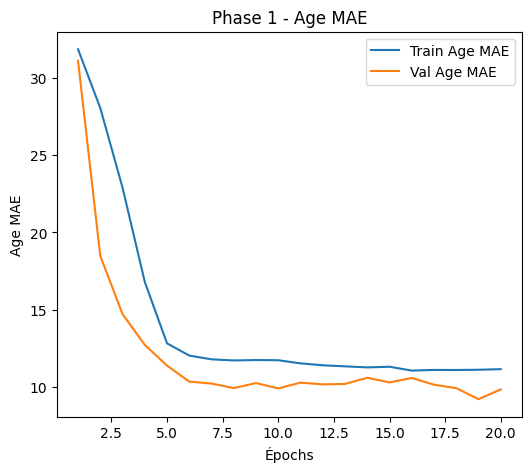

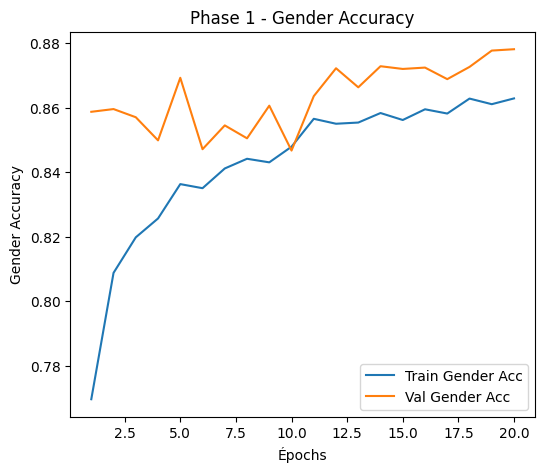

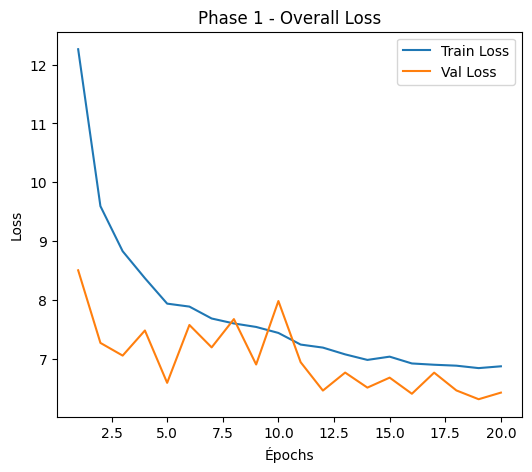

In [75]:
# Affichage des courbes pour la phase 1
plot_training_history_separate(history, "Phase 1")

In [ ]:
# --- Phase 2 : Fine-tuning partiel (débloquer 25% des dernières couches de base_model) ---
num_layers_to_unfreeze = int(0.40 * len(base_model.layers))
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Utilisation de SGD avec momentum et d'un learning rate plus élevé pour la Phase 2
with tf.device("/GPU:0"):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),
        loss={"gender": "binary_crossentropy", "age": weighted_mae},
        metrics={"gender": "accuracy", "age": "mae"},
        loss_weights={"age": 10, "gender": 20}  # Vous pouvez aussi ajuster ces poids
    )
    history_tuning = model.fit(
        train_dataset,
        epochs=40,
        validation_data=val_dataset,
        callbacks=callbacks,
        initial_epoch=history.epoch[-1]
    )

Epoch 20/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 85s 448ms/step - age_loss: 0.1112 - age_mae: 16.3255 - gender_accuracy: 0.6898 - gender_loss: 0.6854 - loss: 14.8214 - val_age_loss: 0.0731 - val_age_mae: 13.6690 - val_gender_accuracy: 0.8328 - val_gender_loss: 0.3742 - val_loss: 8.2475 - learning_rate: 1.0000e-05
Epoch 21/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 424ms/step - age_loss: 0.1019 - age_mae: 16.1169 - gender_accuracy: 0.7543 - gender_loss: 0.5121 - loss: 11.2616 - val_age_loss: 0.0800 - val_age_mae: 13.3724 - val_gender_accuracy: 0.8127 - val_gender_loss: 0.4111 - val_loss: 8.9863 - learning_rate: 1.0000e-05
Epoch 22/40
149/149 ━━━━━━━━━━━━━━━━━━━━ 63s 423ms/step - age_loss: 0.0980 - age_mae: 15.5309 - gender_accuracy: 0.7727 - gender_loss: 0.4753 - loss: 10.4848 - val_age_loss: 0.0835 - val_age_mae: 13.1709 - val_gender_accuracy: 0.8115 - val_gender_loss: 0.4085 - val_loss: 8.9694 - learning_rate: 1.0000e-05
Epoch 23/40
124/149 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - age_loss: 0.1046 - age

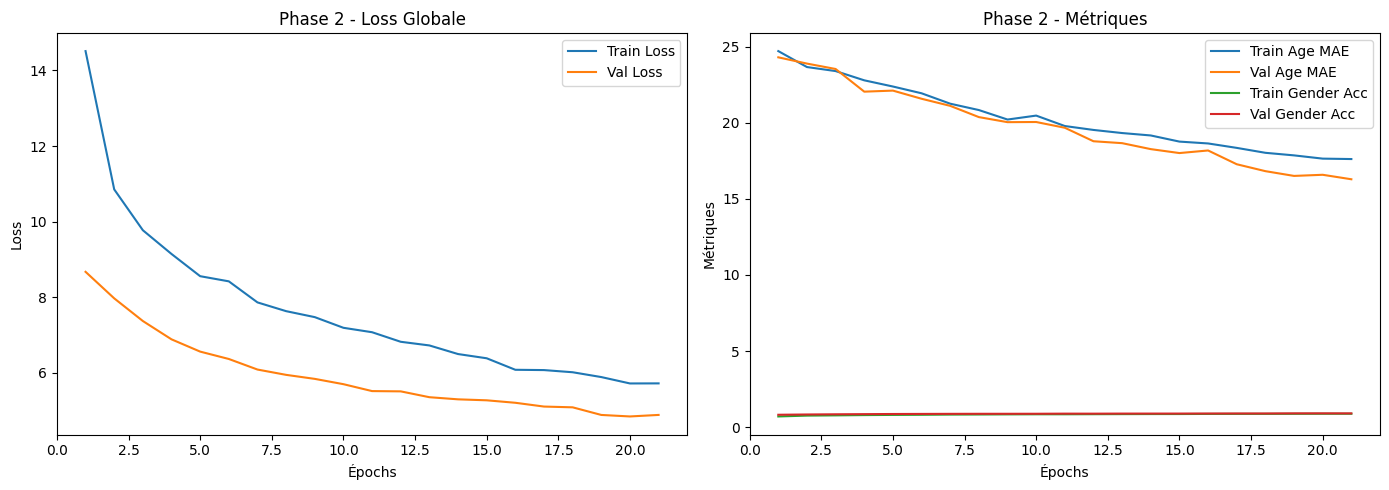

In [34]:
# Affichage des courbes pour la phase 2
plot_training_history_separate(history_tuning, "Phase 2")

In [36]:
# --- Phase 3 : Fine-tuning complet (débloquer l'intégralité du modèle) ---
base_model.trainable = True

with tf.device("/GPU:0"):
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
      loss={"gender": "binary_crossentropy", "age": weighted_mae},
      metrics={"gender": "accuracy", "age": "mae"},
      loss_weights={"age": 10, "gender": 20},
  )

  history_final = model.fit(
      train_dataset,
      epochs=60,
      validation_data=val_dataset,
      callbacks=callbacks,
      initial_epoch=history_tuning.epoch[-1]
  )

Epoch 40/60
297/297 ━━━━━━━━━━━━━━━━━━━━ 110s 241ms/step - age_loss: 0.0995 - age_mae: 17.9402 - gender_accuracy: 0.8013 - gender_loss: 0.4337 - loss: 8.7728 - val_age_loss: 0.0693 - val_age_mae: 16.2858 - val_gender_accuracy: 0.8585 - val_gender_loss: 0.3447 - val_loss: 6.9677 - learning_rate: 1.0000e-06
Epoch 41/60
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - age_loss: 0.0987 - age_mae: 18.2522 - gender_accuracy: 0.8086 - gender_loss: 0.4228 - loss: 8.5548 - val_age_loss: 0.0714 - val_age_mae: 17.0871 - val_gender_accuracy: 0.8484 - val_gender_loss: 0.3535 - val_loss: 7.1167 - learning_rate: 1.0000e-06
Epoch 42/60
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - age_loss: 0.1024 - age_mae: 18.2425 - gender_accuracy: 0.8170 - gender_loss: 0.4059 - loss: 8.2202 - val_age_loss: 0.0718 - val_age_mae: 17.2741 - val_gender_accuracy: 0.8513 - val_gender_loss: 0.3477 - val_loss: 7.0036 - learning_rate: 1.0000e-06
Epoch 43/60
297/297 ━━━━━━━━━━━━━━━━━━━━ 69s 231ms/step - age_loss: 0.0954 - age_

KeyboardInterrupt: 

In [ ]:
# Affichage des courbes pour la phase 3
plot_training_history_separate(history_final, "Phase 3")

# **SECTION 7 : Évaluation sur des images de test**

In [ ]:
def test_images(directory, model, images_x=3, images_y=3):
    """Affiche quelques prédictions sur des images issues d'un dossier test."""
    plt.figure(figsize=(15, 7))
    files = os.listdir(directory)
    random.shuffle(files)
    for i, file in enumerate(files[:images_x * images_y]):
        try:
            actual_age, actual_gender = map(int, file.split("_")[:2])
        except:
            continue
        image = get_image(os.path.join(directory, file))
        plt.subplot(images_y, images_x, i + 1)
        plt.axis("off")
        plt.imshow((image + 1) / 2)  # ajustement pour l'affichage
        prediction = model.predict(np.expand_dims(image, axis=0))
        pred_age = round(prediction[0][0][0])
        pred_gender = round(prediction[1][0][0])
        plt.title(f"Âge réel: {actual_age} / Préd: {pred_age}\nGenre réel: {genders[actual_gender]} / Préd: {genders[pred_gender]}",
                  fontsize=8)
    plt.tight_layout()
    plt.show()

In [ ]:
# Test sur le dossier de test
test_images(data_paths["test"], model)

# **SECTION 8 : Rapport final et analyse du modèle**

In [ ]:
# Évaluation globale sur l'ensemble de validation
evaluation = model.evaluate(val_dataset)
print("\nÉvaluation finale sur l'ensemble de validation :")
print(evaluation)

In [ ]:
# Récupération des prédictions sur l'ensemble de validation pour l'analyse détaillée
all_true_age = []
all_true_gender = []
all_pred_age = []
all_pred_gender = []

for images_batch, (age_batch, gender_batch) in val_dataset:
    preds = model.predict(images_batch)
    pred_age_batch = preds[0].flatten()
    pred_gender_batch = preds[1].flatten()
    all_true_age.extend(age_batch.numpy())
    all_true_gender.extend(gender_batch.numpy())
    all_pred_age.extend(pred_age_batch)
    all_pred_gender.extend(pred_gender_batch)

In [ ]:
# --- Analyse pour la prédiction de l'âge ---
plt.figure(figsize=(6, 6))
plt.scatter(all_true_age, all_pred_age, alpha=0.5)
plt.plot([min(all_true_age), max(all_true_age)], [min(all_true_age), max(all_true_age)], 'r--')
plt.xlabel("Âge réel")
plt.ylabel("Âge prédit")
plt.title("Âge réel vs Âge prédit")
plt.show()

age_errors = np.abs(np.array(all_true_age) - np.array(all_pred_age))
plt.figure(figsize=(6, 4))
sns.histplot(age_errors, kde=True)
plt.xlabel("Erreur absolue")
plt.title("Distribution des erreurs absolues pour l'âge")
plt.show()

In [ ]:
# --- Analyse pour la prédiction du genre ---
# Conversion de la sortie sigmoid en label (0 ou 1)
all_pred_gender_labels = [1 if p >= 0.5 else 0 for p in all_pred_gender]
cm = confusion_matrix(all_true_gender, all_pred_gender_labels)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion pour la prédiction du genre")
plt.show()

In [ ]:
print("Rapport de classification pour le genre :")
print(classification_report(all_true_gender, all_pred_gender_labels, target_names=["Male", "Female"]))

# **SECTION 9 : Sauvegarde du modèle final**

In [ ]:
model.save("final_model.keras")
print("Modèle final sauvegardé au format .keras")